# Procesamiento de imágenes con Keras

Keras es una librería de *deep learning* o aprendizaje profundo, construida sobre TensorFlow. Podemos usarla para transformar nuestros datos de imagenes en matrices. A menurdo, utilizamos aprendizaje profundo para hacer el procesamiento de imágenes. En este ejemplo, usaremos Naive Bayes para luego demostrar cómo el aprendizaje profundo funcionará mucho mejor que Naive Bayes.

In [1]:
import numpy as np # algebra lineal
import pandas as pd # procesamiento de datos, I/O para CSV
import seaborn as sns

from subprocess import check_output

import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

Using TensorFlow backend.


### Procesar imágenes como matrices

In [2]:
# # Crear un conjunto de datos de memes
folder_1 = "memes"

# Crear una lista de archivos en la carpeta especificada
meme_files = [f for f in os.listdir(folder_1) if os.path.isfile(os.path.join(folder_1, f))]

print("Working with {0} images".format(len(meme_files)))
print("Image examples: ")

# Imprimir dos ejemplos usando display (_Imgdis ()), que puede leer los archivos de imagen
for i in range(150, 152):
    print(meme_files[i])
    display(_Imgdis(filename=folder_1 + "/" + meme_files[i], width=240, height=320))

Working with 202 images
Image examples: 
image_189.png
image_57.png


In [3]:
# Crear un conjunto de datos de no-memes, extraído de este conjunto de datos:
# http://press.liacs.nl/mirflickr/mirdownload.html

#folder_0 = "non_memes"
folder_0 = "no-memes"

# Crear una lista de los archivos que están en esa carpeta
non_meme_files = [f for f in os.listdir(folder_0) if os.path.isfile(os.path.join(folder_0, f))]

print("Working with {0} images".format(len(non_meme_files)))
print("Image examples: ")

# Imprima dos ejemplos usando display (_Imgdis ()), que puede leer los archivos de imagen
#for i in range(150, 152):
for i in range(2):
    print(non_meme_files[i])
    display(_Imgdis(filename=folder_0 + "/" + non_meme_files[i], width=240, height=320))

Working with 184 images
Image examples: 
8623550408_d65bbd8897_o.jpg
14589191718_5bc1209260_o.jpg


In [4]:
## Preparar arrays para guardar los datos en un formato adecuado
y_data = [1]*len(meme_files) + [0]*len(non_meme_files)
meme_colors = np.ndarray(shape = (len(meme_files), 3), dtype=np.float32)
non_meme_colors = np.ndarray(shape = (len(non_meme_files), 3), dtype=np.float32)
image_size_areas = []

# Dimensiones para estandarizar las imágenes
image_height = 120
image_width = 160
channels = 3

# Hacer una matriz de 3 dimensiones (3 para RGB o número de canales)

dataset = np.ndarray(shape=(len(y_data), channels, image_height, image_width), dtype=np.float32)

In [5]:
# Agregar una matriz de cada imagen de meme a nuestro dataset (ten en cuenta que este código
# se puede mejorar creando una función read_image en lugar de repetir el bucle for dos veces)

i = 0
for j in range(len(meme_files)):
    img = load_img(folder_1 + "/" + meme_files[j])#esta es una imagen PIL
    #Guardar dimensiones iniciales antes de cambiar el tamaño
    image_size_areas.append(img.size[0] * img.size[1])
    img = img.resize((image_height, image_width))
    # Convertir a numpy array y guardar colores
    x = img_to_array(img)
    meme_colors[j] = [x[0].sum(), x[1].sum(), x[2].sum()]
    x = x.reshape((channels, image_height, image_width))
    try:
        dataset[i] = x
        i += 1
        if i % 250 == 0:
            print("%d images to array" % i)
    except Exception as e:
        i += 1
        print("failed on %d" %i, e)

# Agregue una matriz de cada imagen no meme a nuestro conjunto de datos
for k in range(len(non_meme_files)):
    img = load_img(folder_0 + "/" + non_meme_files[k])  # this is a PIL image
    # Guardar dimensiones iniciales antes de cambiar el tamaño
    image_size_areas.append(img.size[0] * img.size[1])
    img = img.resize((image_height, image_width))
    # Convertir a numpy array y guardar colores
    x = img_to_array(img)
    non_meme_colors[k] = [x[0].sum(), x[1].sum(), x[2].sum()]
    x = x.reshape((channels, image_height, image_width))
    try:
        dataset[i] = x
        i += 1
        if i % 250 == 0:
            print("%d images to array" %i)
    except Exception as e:
        i += 1
        print("failed on %d" %i, e)

250 images to array


### Análisis Exploratorio

In [6]:
# Determinar la proporción de meme versus no meme
print(len(y_data))
print("memes:", sum(y_data)/len(y_data), "non-memes:", (len(y_data)-sum(y_data))/len(y_data))

386
memes: 0.5233160621761658 non-memes: 0.47668393782383417


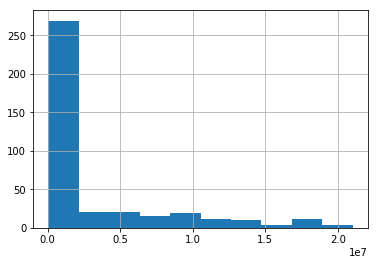

In [7]:
# Graficar la distribución de tamaños antes de que se recortaran las imágenes
pd.Series(data = image_size_areas).hist()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


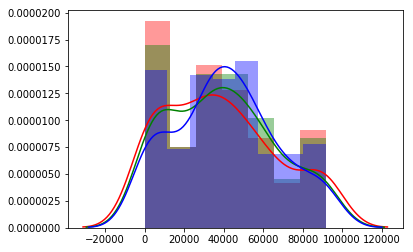

In [8]:
# Graficar un histograma de colores para memes
sns.distplot(meme_colors[:,0], color = 'r')
sns.distplot(meme_colors[:,1], color = 'g')
sns.distplot(meme_colors[:,2], color = 'b')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


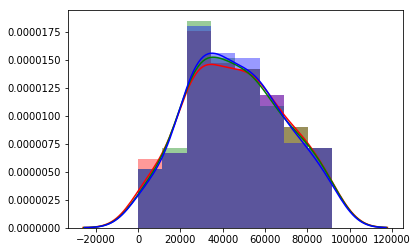

In [9]:
# Graficar un histograma de colores para no memes
sns.distplot(non_meme_colors[:,0], color = 'r')
sns.distplot(non_meme_colors[:,1], color = 'g')
sns.distplot(non_meme_colors[:,2], color = 'b')

### Construir el modelo

In [10]:
# El modelo espera un arreglo de 2 dimensiones, así que \"aplanamos \" nuestro arreglo
# de 4 dimensines a 2 dimensiones.
dataset_flattened = dataset.reshape(len(y_data) * channels, image_height * image_width)
y_data_flattened = [1]*len(meme_files)*3 + [0]*len(non_meme_files)*3

In [11]:
print(len(dataset_flattened), len(dataset)*3)

1158 1158


In [12]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(dataset_flattened, y_data_flattened, test_size=0.2, random_state=33)

In [13]:
# Probar la aleatoriedad del conjunto y_train y y_test
print(sum(y_train)/len(y_train), sum(y_test)/len(y_test))

0.5140388768898488 0.5603448275862069


In [14]:
# Entrenar un clasificador NB multinomial de la biblioteca sklearn
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
# Probar el modelo en los datos de prueba
preds = nb.predict(X_test)

# Imprimir la precisión del modelo
accuracy = (preds == y_test)
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

'Accuracy : 60.78%'

Source: https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays